<img src="banner.png">

# Graph Search y Shortest Path: armando mi propio Google Maps

## Introducción

Uno de los problemas más interesantes para resolver con Grafos es, sin dudas, el camino más corto. Es un problema que, por suerte, pudo resolverse de manera muy eficiente con distintos métodos. Cualquier servicio hoy en día ejecuta rutinas para calcular el camino más corto y cumplir una determinada tarea.

El ejemplo más claro, que se nos viene a la mente es el servicio de mapas online como Google Maps, pero hay miles de aplicaciones. Un caso moderno es el de los satélites Starlink: ¿Cómo encontramos el camino más corto ruteando una señal desde un punto A a un punto B, aprovechando un híbrido entre satélites y estaciones de tierra? tratado en un estudio de Mark Handley para el University College London.

En este notebook, vamos a ir por lo que siempre nos preguntamos: ¿Cómo funciona Google Maps y cómo puedo hacerlo yo?

Info adicional:
- Paper de ruteo de Starlink: https://people.eecs.berkeley.edu/~sylvia/cs268-2019/papers/starlink.pdf
- Video de ruteo de starlink: https://www.youtube.com/watch?v=m05abdGSOxY

## Notas iniciales de configuración

Para los que usan Anaconda, es necesario instalar:
- Mediante .whl: GDAL, Fiona
- En la consola de anaconda: conda install shapely

## Herramientas
**OSMNX** es un paquete que toma información del mapa open-source [OpenStreetMap](https://www.openstreetmap.org) y convierte destintos puntos de interés en un grafo del paquete **NetworkX**. Esta última, es una poderosa librería que permite estudiar grafos e implementar sobre ellos una variedad enorme de algoritmos y métricas.

Info:
- https://osmnx.readthedocs.io/en/stable/
- https://networkx.org/

In [14]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
from time import time

## Pedido de Spatial Data con OSMNX

En este punto vamos a pedir información a OpenStreetMap mediante la librería OSMNX. La idea es que nos devuelva de una región lo que se conoce como "Spacial Data", que son datos de ubicación geográfica que podemos usar para armar un grafo dirigido.

Entremos en tema: me imagino saliendo de la Facultad muy tarde de un parcial y con un hambre voraz. En mi cabeza, una sola idea: La Birra Bar. ¿Cómo llego?

Vamos a empezar seleccionando los dos puntos en un mapa, representados por su latitud y longitud en una lista de Python. Podemos buscar estos datos, por ejemplo, en Google Maps.

In [15]:
origen = [-34.59852482887617, -58.41983151401766] # La UTN en Medrano 951
destino = [-34.594668472929776, -58.438509534699804] # La Birra Bar de Villa Crespo

A continuación calculamos el *centroide* que representa el centro de masa de todos los puntos que indicamos, en este caso, solamente origen y destino.

In [16]:
locations = [origen, destino]
coordsz = list(zip(*locations))
centroid = [sum(coordsz[0])/len(locations), sum(coordsz[1])/len(locations)]

Armarmos el grafo desde el centroide y automáticamente la línea *graph_from_point(.)* hace el requerimiento de información.

Los nodos que obtenemos, son de intersecciones de calles y puntos importantes varios. Lo que nos interesa, es marcar en el mapa los nodos más cercanos a los orígenes y destinos que indicamos. Estos últimos, pueden o no coincidir con un nodo del grafo.

Por último ploteamos el grafo espacial, que puede ser visualizado como un mapa.

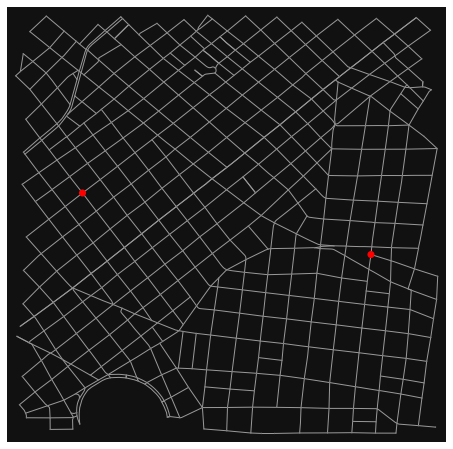

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [17]:
# Armar el grafo desde el centroide:
G = ox.graph_from_point(centroid, network_type='drive', dist=1200)

# Calcular nodos más cercanos a origen y destino:
target = [ox.get_nearest_node(G, coordi) for coordi in locations]

# Cambiar color de origen y destino:
nconf = [('r', 50) if node in (target) else ('gray', 2) for node in G.nodes()]
nconf = list(zip(*nconf))

# Plot y display:

ox.plot_graph(G, node_color=nconf[0], node_size=nconf[1])

Podríamos ver el anterior plot y pensar: "esto no parece un grafo", y es porque está ploteado como un mapa, sin los arcos dirigidos y los nodos. Además, los nodos ocultos, están ubicados geográficamente.

Si queremos plotear el grafo dirigido, podemos hacerlo con la librería **NetworkX**, con el grafo que obtuvimos anteriormente.

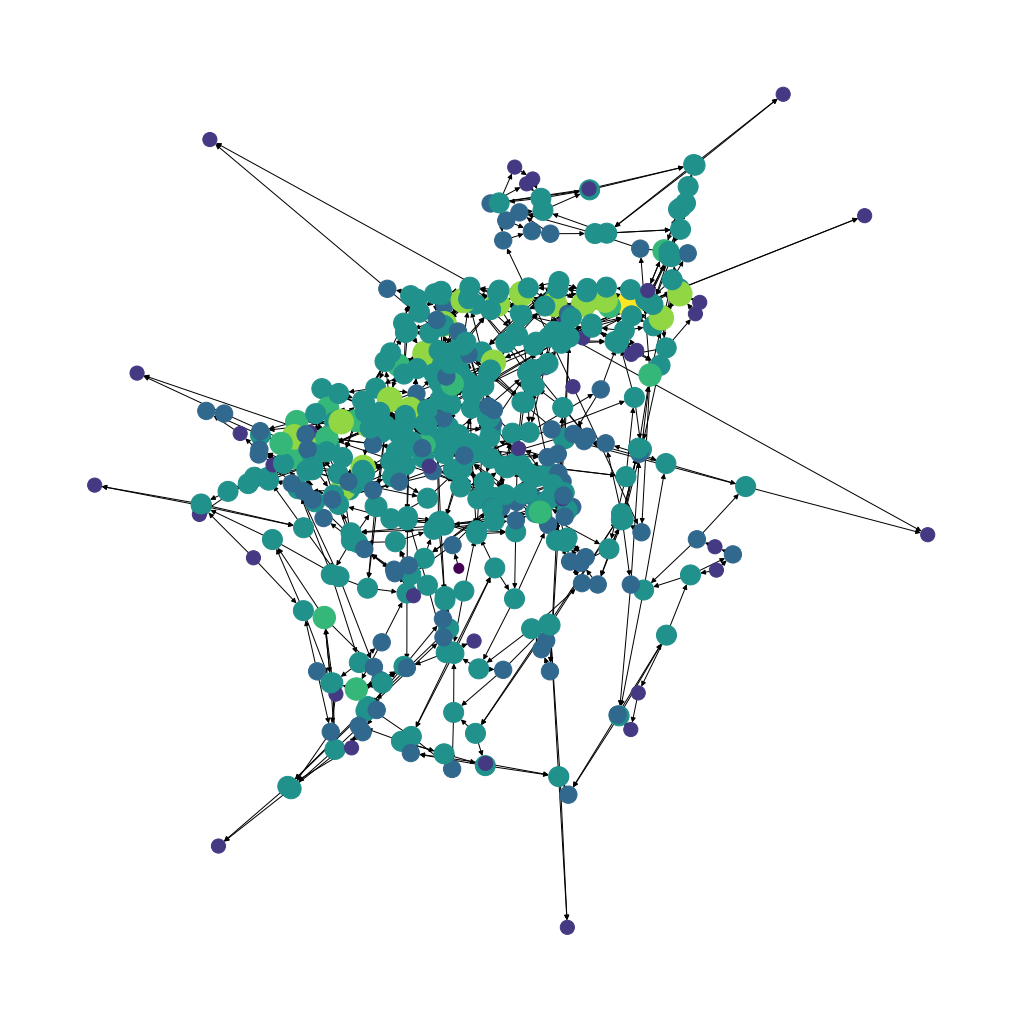

In [18]:
# Cambiar color y tamaño de los nodos de acuerdo al grado de los nodos:
deg = G.degree
n_color = np.asarray([deg[n] for n in G.nodes])
n_size = [v * 100 for v in dict(G.degree).values()]

# Plot y display:
plt.figure(3,figsize=(14,14)) 
nx.draw(G, node_size=n_size, node_color=n_color)
plt.show()

## Cálculo del camino más corto con NetworkX

Ya tenemos nuestro grafo cargado como un objeto de **NetworkX**, por lo tanto podemos aprovechar sus métodos y calcular el camino más corto entre dos nodos.

Sabemos que los arcos representan las distancias entre un nodo y otro, es decir, la longitud de las calles. Pero también, hay que tener en cuenta, que éste no es un grafo completo. Recordemos que no todas las calles son doble mano, y por lo tanto no es lo mismo ir desde el nodo A al B, que del B al A. 

Lo último tiene efecto en la matriz Nodo-Nodo. Recordemos que esta matriz, en cada posición, representa la distancia entre un nodo y otro. Por lo tanto, la matriz no es simétrica, al no asegurar que pueda volver exactamente por el mismo camino de ida.

Calcular el camino más corto en esta librería es tan simple como llamar al método *.shortest_path(.)", e indicarle como argumentos: el grafo, el origen y el destino.

Por último ploteamos el mapa y el camino calculado.

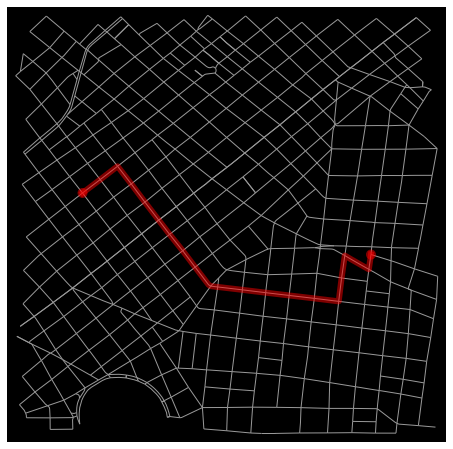

In [19]:
# Punto más cercano a orígines y destinos:
orig = ox.get_nearest_node(G, origen, method='euclidean')
dest = ox.get_nearest_node(G, destino, method='euclidean')

# Calcular shortest path con Networkx
route = nx.shortest_path(G, orig, dest)

# Plot y display:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

## Mi camino más corto: el algoritmo de Dijkstra

Lo anterior es muy interesante, pero no hicimos más que aplicar una librería. ¿Cómo calculamos nuestro camino más corto?

La respuesta está en un algoritmo muy famoso: Dijkstra.

Es un algoritmo de búsqueda en grafos, que permite calcular el camino más corto entre un origen y un destino. Lo hace de manera iterativa, actualizando etiquetas sobre los nodos, que son los mejores resultados hasta determinada iteración, del camino más corto logrado.

Es un algoritmo que no tiene heurística, pero puede llegar a la solución óptima.

En [este video](https://www.youtube.com/watch?v=GazC3A4OQTE) podemos ver una explicación sobre su funcionamiento.

Podemos encontrar una aplicación simple en el siguiente pseudocódigo:
```
"""
# Objetos:
nodos_no_explorados: lista de nodos no explorados
predecesor: lista de predecesores de cada nodo
vecinos: lista de vecinos de cada nodo
etiqueta: lista de etiquetas
distancia: lista de pesos de arcos
"""

# Nodos no explorados:
nodos_no_explorados = todos los nodos del grafo

# Inicializar etiquetas:
PARA CADA nodo_i en el grafo:
|	etiqueta[nodo_i] = infinito
|	predecesor[nodo_i] = 0
    
peso(nodo_origen) = 0

# Iterar:
MIENTRAS lista nodos_no_explorados esté llena:
|	head = nodo con menor peso en nodos_no_explorados
|	quitar el nodo head de nodos_no_explorados
|	
|	para cada vecino_i de head:
|	|   etiqueta_potencial = etiqueta[head] + distancia[head, vecino_i]
|    |     
|    |   # actualizo etiquetas:
|	|	SI peso_potencial < peso[vecino_i]:
|	|	|	etiqueta[vecino_i] = etiqueta_potencial
|	|	|	predecesor[vecino_i] = head
```

Antes de armar nuestro algoritmo, presentamos un caso ejemplo, muy simple, sobre el cual aplicarlo para hacer pruebas iniciales. Es un grafo de 6 nodos y la idea es llegar en el camino más corto desde el nodo 0 al 5.

Para poder visualizar este grafo pequeño, usamos NetworkX:

{(0, 1): Text(-0.9775716582471932, 0.14094686065747408, '0.3'),
 (0, 2): Text(-0.5684843042877111, 0.36354582582278094, '0.5'),
 (1, 2): Text(-0.5873447543651458, -0.02183357168550029, '0.2'),
 (1, 5): Text(-0.4166034795698802, -0.3279292457573352, '0.15'),
 (2, 3): Text(0.41087129979716813, 0.38967202008545276, '0.2'),
 (2, 5): Text(-0.007516125610398147, -0.10533028059202831, '0.8'),
 (5, 4): Text(0.5667003584500251, -0.5306188807429268, '0.5'),
 (3, 4): Text(0.9850877838575913, -0.03561658006544577, '0.1')}

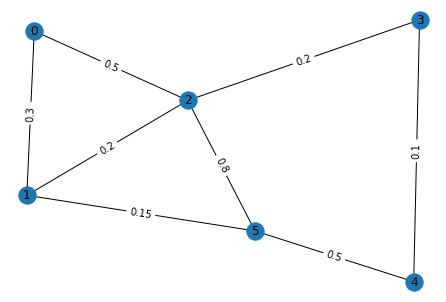

In [20]:
# Datos de adyacencia y pesos en el grafo:
datos = {(0, 1): 0.3, (0, 2): 0.5, (1, 2): 0.2, (1, 5): 0.15,
         (2, 3): 0.2, (3, 4): 0.1, (4, 5): 0.5, (2, 5): 0.8}

# Construimos el grafo con Networkxs:
K = nx.Graph()
[K.add_edge(*key, weight=value) for key, value in datos.items()]

# Lo ploteamos:
pos = nx.spring_layout(K)
nx.draw(K, pos, with_labels=True)
nx.draw_networkx_edge_labels(K, pos, edge_labels=nx.get_edge_attributes(K,'weight'))

A continuación, vamos a armar el algoritmo de Dijkstra en una función. La misma va a recibir como argumentos:

- El índice del origen
- El índice del destino
- Un diccionario de origen-destino con los pesos de los arcos, es decir: {(desde, hasta): peso, ...}
- La cantidad total de nodos en el grafo

De forma iterativa el algoritmo va a ir eligiendo un nodo "head" y actualizando las etiquetas de sus vecinos en la lista "etiqueta". Este nodo "head", una vez explorado, se completa y no se vuelve a revisar.

Además, en cada paso, vamos actualizando una lista de predecesores, para poder reconstruir el camino al final.

Un aspecto muy interesante del algoritmo de Dijkstra, es que al finalizar, no solo se puede recuperar el camino más corto de un punto A a B, sino todos los caminos más cortos entre A y cualquier nodo del grafo.

In [21]:
def calcular_dijkstra(origen, destino, datos, q_nodos):

    # Inicializar:
    ## Inicializamos con infinito la lista de etiquetas.
    etiqueta = [np.inf for i in range(0,q_nodos)]
    ## Al origen le ponemos la etiqueta 0.00, es decir, 0 distancia recorrida.
    etiqueta[origen] = 0.00
    ## Convertimos el diccionario con datos de adyacencia en una lista de adyacencias:
    vecinos = [[] for i in range(0,q_nodos)]
    [vecinos[i].append(j) for i, j in datos.keys()]
    # Inicializamos la lista de predecesores:
    predecesor = [0 for i in range(0,q_nodos)]
    # Inicializamos la lista de nodos no explorados y explorados:
    nodos_no_explorados = [origen]
    nodos_explorados = []
  

    # Iterar para cada nodo no explorado:
    while nodos_no_explorados:
        # Sacamos de la lista de no explorado el primero y lo indicamos como "head".
        head = nodos_no_explorados.pop(0)
        
        # Para cada vecino del head:
        for vecino_i in vecinos[head]:
            # Calculamos la etiqueta potencial como la etiqueta del head más la distancia entre el head y el vecino:
            etiqueta_potencial = etiqueta[head] + datos[(head, vecino_i)]
            
            # Si la etiqueta potencial es menor a la del vecino:
            if etiqueta_potencial < etiqueta[vecino_i]:
                # Actualizamos la etiqueta del vecino y guardamos al head como su predecesor:
                etiqueta[vecino_i] = etiqueta_potencial
                predecesor[vecino_i] = head
            
            # Agregamos al vecino a la lista de no explorados si es que no se exploró todavía:
            nodos_no_explorados.append(vecino_i) if vecino_i not in nodos_explorados else None
        
        # Una vez recorridos todos los vecinos, ponemos al head como explorado.
        nodos_explorados.append(head)
        
    # Partiendo de la lista de predecesores, calculamos el camino:
    path = [destino]
    
    i = destino
    while i != origen:
        pred = predecesor[i]
        path.append(pred)
        i = pred
    
    path.reverse()
    
    # retornamos el camino:
    return path, etiqueta[destino]

Ahora que ya tenemos nuestro propio algoritmo de Dijkstra, vamos a aplicarlo al grafo de ejemplo, viajando del nodo 0 al 5:

In [22]:
path_ej, distancia_ej = calcular_dijkstra(0, 5, datos, 6)

print(f"Camino ordenado: {path_ej}, distancia: {distancia_ej}")

Camino ordenado: [0, 1, 5], distancia: 0.44999999999999996


Antes de tirar nuestra función encima de nuestro problema para llegar a La Birra Bar, necesitamos transformar la información que nos da OSMNX en la entrada de nuestra función.

Los nodos del grafo NetworkX se obtienen con el método *.nodes* sobre el grafo, y están codificados. Por lo tanto, cuando obtenemos la información de los arcos mediante el método *.edges*, vamos a encontrar que los datos "desde-hasta" están escritos con este código. Para nuestro algoritmo, no podemos ingresar estos códigos; en su lugar vamos a indicar los índices que tienen esos nodos en la lista de nodos que obtuvimos con el método *.nodes*.

Por ejemplo, si la lista de códigos es: [89839289, 92839302, ...] y la información desde-hasta: (89839289, 92839302), necesitamos obtener: desde: 0, hasta 1; teniendo en cuenta que 0 es 89839289 y 1 92839302.

Por último, del método *.edges* también podemos obtener los pesos de los arcos.

Con todo esto, vamos a armar un diccionario "datos_mapa" con la estructura: {(desde, hasta): peso} que vimos anteriormente.

In [23]:
# Obtenemos la lista con códigos de nodos:
nodos = list(G.nodes)

# Llamamos a la información de los arcos:
a = dict(G.edges)
# Extraemos los valores de los pesos en una lista:
values = [i['length'] for i in a.values()]
# Extraemos los valores desde-hasta y lo guardamos en una lista de tuplas. Estos serán las claves:
keys = [(nodos.index(i), nodos.index(j)) for i, j, _ in a.keys()]
# Construimos el diccionario con datos "desde-hasta-peso" con los valores de pesos y claves origen-destino:
datos_mapa = dict(zip(keys, values))

Antes de ingresar todo al algoritmo, también necesitamos escribir los nodos de origen y destino como índices que apuntan a la lista de Nodos y no como códigos OSMNX. Esto lo hacemos buscando en qué posición de la lista de nodos está el código de origen y el código de destino:

In [27]:
indice_orig = nodos.index(orig)
indice_dest = nodos.index(dest)

Llamamos a nuestra función de Dijkstra e ingersamos: índice de origen y destino, datos de pesos de arcos y cantidad de nodos.

Englobamos a todo dentro de un time(), para saber el tiempo de cómputo.

In [34]:
t0 = time()

path, dist = calcular_dijkstra(indice_orig, indice_dest, datos_mapa, len(nodos))

t = time() - t0

print(f"Camino ordenado (índices): {path},\nDistancia: {dist} metros,\nTiempo de cómputo: {t} segs")

Camino ordenado (índices): [12, 268, 267, 457, 455, 259, 25, 81, 120, 24, 23, 22, 21, 20, 19, 193, 203, 204, 205, 206],
Distancia: 2072.515 metros,
Tiempo de cómputo: 0.265610933303833 segs


Por último, para visualizarlo, convertimos los índices de nodos en códigos de OSMNX, e ingresamos el camino en el plot.

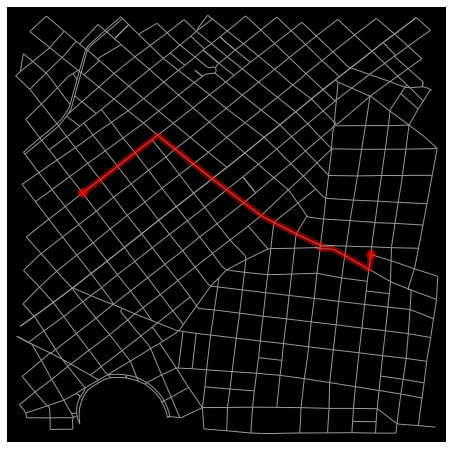

In [32]:
# Convertimos los índices de nodos a código OSMNX:
path_osmnx = [nodos[i] for i in path]

# Plot y display:
fig, ax = ox.plot_graph_route(G, path_osmnx, route_linewidth=6, node_size=0, bgcolor='k')

¡Impresionante, ya tenemos nuestro propio Google Maps!

## Conclusiones y desarrollo adicional

En este Notebook: 
- pudimos ver cómo se pide información geográfica con librerías de python.
- puedimos entender cómo se convierte esa información en grafos dirigidos para poder hacer cálculos sobre ellos.
- y armamos nuestro propio algoritmo de camino más corto.

Los mapas, tienen muchísimas más funciones y trabajan con volúmenes de datos enormes. Los caminos que en general entregan, no están directamente calculados con Dijsktra, aunque usan procedimientos muy similares.

Por otro lado, esos servicios, no siempre entregan un óptimo, y no es que no puedan calcularlo, sino que hay un trade-off entre la calidad de la solución entregada y el tiempo de cómputo. A veces un resultado subóptimo en menos tiempo, es mucho mejor. Por otro lado, los mapas sirven a millones de personas y tienen que balancear su esfuerzo computacional.

No solamente el volumen es más complejo, sino también los datos involucrados. Los servicios de mapas no calculan caminos más cortos con distancias, sino con la información actualizada del tráfico. Por eso, se generan series de tiempo, en donde un camino puede ser óptimo a las 18:00 pero no a las 10:30.

Con esto último, planteo las preguntas:
1. ¿Cómo se calcularía el camino más corto con información actualizada del tráfico?
2. ¿Qué pasa si tenemos time-windows, es decir, quiero llegar a mi destino en el camino más corto en distancia, pero antes de determinado horario?